In [523]:
import numpy as np
import math 
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [524]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

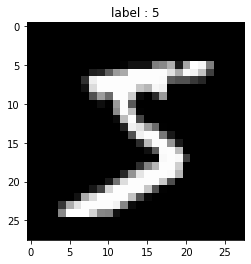

In [525]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [526]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [527]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [528]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [646]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

【問題1】全結合層のクラス化

In [738]:
class FC_B:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2,initializer,optimizer):        
        self.n_nodes1=n_nodes1
        self.n_nodes2=n_nodes2
        self.initializer = initializer
        self.W1=self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B1=self.initializer.B(self.n_nodes2)        
        self.optimizer = optimizer
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        
        A=X@self.W1+self.B1
        self.A=A
        return A

    
    def backward(self, dA,Z):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
               
        # 「3層目」
        self.B2=np.sum(dA, axis=0)
        self.W2=Z.T@dA
        dZ=dA@self.W1.T
        
        #　参考で残す
        #self.B1=self.B1-self.lr*self.B2
        #self.W1=self.W1-self.lr*self.W2
        
        # 更新
        self.B1,self.W1 = self.optimizer.update(self.B1,self.W1,self.B2,self.W2)
    
        return dZ

（サンプルで確かめるための実行）

In [675]:
class ScratchSimpleNeuralNetrowkClassifier_B():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self,ite_num, first_nodes,second_nodes,third_nodes,verbose = True):
        self.verbose = verbose
        self.ite_num=ite_num
        self.first_nodes=first_nodes
        self.second_nodes=second_nodes
        self.third_nodes=third_nodes
        self.loss = []
        self.val_loss = []      

 
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """ 
        #　初期設定の処理
        #  シグモイドを前提とした設定
        SI1=SimpleInitializer(1/math.sqrt(X.shape[1]))
        optimizer1=SGD(0.1)
        self.FC1 = FC_B(X.shape[1],self.first_nodes,SI1,optimizer1)
        self.activation1=Sigmo_func()
        
        SI2=SimpleInitializer(1/math.sqrt(self.first_nodes))
        optimizer2=SGD(0.1)
        self.FC2 = FC_B(self.first_nodes,self.second_nodes,SI2,optimizer2)
        self.activation2=Sigmo_func()
        
        SI3=SimpleInitializer(1/math.sqrt(self.second_nodes))
        optimizer3=SGD(0.1)
        self.FC3 = FC_B(self.second_nodes,self.third_nodes,SI3,optimizer3)
        self.activation3=Softmax_func()
        
        
        # 処理を行う
        for _ in range(self.ite_num):
            get_mini_batch = GetMiniBatch(X,y,batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワード
                A1=self.FC1.forward(mini_X_train)
                Z1=self.activation1.Sigmo_func_f(self.FC1.forward(mini_X_train))
                A2=self.FC2.forward(Z1)
                Z2=self.activation2.Sigmo_func_f(A2)
                A3=self.FC3.forward(Z2)
                Z3=self.activation3.softmax_func_f(A3)
                # バック
                dA3=self.activation3.softmax_func_b(mini_y_train)
                dZ2=self.FC3.backward(dA3,Z2)
                dA2 = self.activation2.Sigmo_func_b(dZ2)
                dZ1 = self.FC2.backward(dA2,Z1)
                dA1 = self.activation1.Sigmo_func_b(dZ1)
                dZ0 = self.FC1.backward(dA1,mini_X_train) # dZ0は使用しない
              
            self.loss.append(self.activation3.total)
            
            if X_val is not None:                             
                A1_val=self.FC1.forward(X_val)
                Z1_val=self.activation1.Sigmo_func_f(self.FC1.forward(X_val))
                A2_val=self.FC2.forward(Z1_val)
                Z2_val=self.activation2.Sigmo_func_f(A2_val)
                A3_val=self.FC3.forward(Z2_val)
                Z3_val=self.activation3.softmax_func_f(A3_val) 
                dA3_val=self.activation3.softmax_func_b(X_val)            
            self.val_loss.append(self.activation3.total)  
            
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """        
        A1=self.FC1.forward(X)
        Z1=self.activation1.Sigmo_func_f(SSNN2.FC1.forward(X))
        A2=self.FC2.forward(Z1)
        Z2=self.activation2.Sigmo_func_f(A2)                
        A3=self.FC3.forward(Z2)
        Z3=self.activation3.softmax_func_f(A3)
        y_pred=np.argmax(Z3, axis=1)
        
        return y_pred

In [676]:
ite_num=10
first_nodes=400
second_nodes=200
third_nodes=10
SSNN1=ScratchSimpleNeuralNetrowkClassifier_B(ite_num,first_nodes,second_nodes,third_nodes)
SSNN1.fit(X_train,y_train, X_val=None, y_val=None)

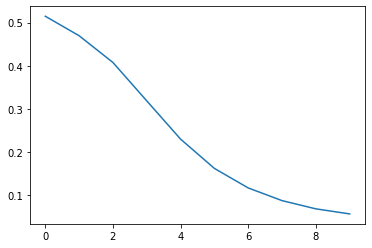

In [739]:
import matplotlib.pyplot as plt
plt.plot(SSNN1.loss)
plt.show()

とりあえず動いていそうなことは確認できた

【問題2】初期化方法のクラス化

In [438]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2,)        
        return B

【問題3】最適化手法のクラス化

In [661]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self,B1,W1,B2,W2):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        self.B1=B1-self.lr*B2
        self.W1=W1-self.lr*W2
        
        return self.B1,self.W1

【問題4】活性化関数のクラス化(シグモイド、ソフトマックス)

In [440]:
# シグモイド関数のクラス
class Sigmo_func:
    """
    活性化関数のシグモイド関数クラス化
    Parameters
    ----------
    """
    def Sigmo_func_f(self, A):
        """
        シグモイド関数のフォワード
        Parameters
        ----------
        """
        self.A=A
        Z=1/(1+np.exp(-A))
        self.Z=Z
        return Z
       
    def Sigmo_func_b(self, Z):
        """
        シグモイド関数のバック
        Parameters
        ----------
        """
        sigmo1=(1-self.Sigmo_func_f(self.A))*self.Sigmo_func_f(self.A)
        A=Z*sigmo1
        return A

In [441]:
# ソフトマックス関数のクラス
class softmax_func:
    """
    活性化関数のソフトマックス関数のクラス化
    Parameters
    ----------
    """
    def softmax_func_f(self, A):
        """
        ソフトマックス関数
        Parameters
        ----------
        """
        Z=np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1) 
        self.Z=Z
        return Z
       
    def softmax_func_b(self, mini_y_train):
        """
        シグモイド関数
        Parameters
        ----------
        """
        # 交差エントロピー誤差
        L = - np.sum(mini_y_train * np.log(self.Z)) / len(mini_y_train)
        self.total=L
        
        # バックプロバケーション
        A=(self.Z-mini_y_train)/len(self.Z)
        self.A=A
        return A

【問題5】ReLUクラスの作成

In [753]:
# ReLUのクラス
class ReLU_func:
    """
    活性化関数のReLU_funcクラス化
    Parameters
    ----------
    """
    def ReLU_f(self, A):
        """
        ReLU_funcのフォワード
        Parameters
        ----------
        """
        self.A=A
        Z=np.where(A<=0,0,A)
        self.Z=Z
        return Z
       
    def ReLU_b(self, Z):
        """
        ReLU_funcのバック
        Parameters
        ----------
        """        
        A=np.where(Z>0,1,0)
        self.A=A
        return A

In [803]:
# ReLUのクラス
class ReLU_func_B:
    """
    活性化関数のReLU_funcクラス化
    Parameters
    ----------
    """    
    def __init__(self):
        # 値を初期化
        self.mask = None
    
    def ReLU_f(self, A):
        """
        ReLU_funcのフォワード
        Parameters
        ----------
        """
        self.A=A

        self.mask = (A <= 0) # 0以下の要素のインデックスを検索
        out = A.copy() # 引数の値をコピー
        out[self.mask] = 0 # 0以下の要素を0に置換        
        Z=out
        self.Z=Z
        return Z
       
    def ReLU_b(self, Z):
        """
        ReLU_funcのバック
        Parameters
        ----------
        """                
        Z[self.mask] = 0 # 0以下の要素を0に置換
        A = Z        
        self.A=A
        return A

【問題6】重みの初期値・・・問題２の初期化をするクラスの中にSimpleInitializerの中に組み込み済

In [652]:
# ReLUのときの Heの初期値の場合

class ScratchSimpleNeuralNetrowkClassifier_C():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self,ite_num, first_nodes,second_nodes,third_nodes,verbose = True):
        self.verbose = verbose
        self.ite_num=ite_num
        self.first_nodes=first_nodes
        self.second_nodes=second_nodes
        self.third_nodes=third_nodes
        self.loss = []
        self.val_loss = []      

 
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """ 
        #　初期設定の処理
        #  ReLUを前提とした設定
        SI1=SimpleInitializer(math.sqrt(2/X.shape[1]))
        optimizer1=SGD(0.1)
        self.FC1 = FC_B(X.shape[1],self.first_nodes,SI1,optimizer1)
        self.activation1=Sigmo_func()

        SI2=SimpleInitializer(math.sqrt(2/self.first_nodes))
        optimizer2=SGD(0.1)
        self.FC2 = FC_B(self.first_nodes,self.second_nodes,SI2,optimizer2)
        self.activation2=Sigmo_func()

        SI3=SimpleInitializer(math.sqrt(2/self.second_nodes))
        optimizer3=SGD(0.1)
        self.FC3 = FC_B(self.second_nodes,self.third_nodes,SI3,optimizer3)
        self.activation3=Softmax_func()
        
        
        # 処理を行う
        for _ in range(self.ite_num):
            get_mini_batch = GetMiniBatch(X,y,batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワード
                A1=self.FC1.forward(mini_X_train)
                Z1=self.activation1.Sigmo_func_f(self.FC1.forward(mini_X_train))
                A2=self.FC2.forward(Z1)
                Z2=self.activation2.Sigmo_func_f(A2)
                A3=self.FC3.forward(Z2)
                Z3=self.activation3.softmax_func_f(A3)
                # バック
                dA3=self.activation3.softmax_func_b(mini_y_train)
                dZ2=self.FC3.backward(dA3,Z2)
                dA2 = self.activation2.Sigmo_func_b(dZ2)
                dZ1 = self.FC2.backward(dA2,Z1)
                dA1 = self.activation1.Sigmo_func_b(dZ1)
                dZ0 = self.FC1.backward(dA1,mini_X_train) # dZ0は使用しない
              
            self.loss.append(self.activation3.total)
            
            #if X_val is not None:
                #self._forward_calculate(X_val)
                #self._cross_entropy_error(y_val)
                #self._back_calculate(X_val,y_val)
                #self.val_loss.append(self.total)
        

【問題7】最適化手法・・・問題３のものを修正した(SGD_Bとする)

In [665]:
class SGD_B:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.HW=0
        self.HB=0
    def update(self,B1,W1,B2,W2):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        #layer : 更新前の層のインスタンス
        """
        
        self.HW=self.HW+np.mean(W2,axis=0)@np.mean(W2,axis=0).T 
        self.W1=W1-self.lr*(1/math.sqrt(self.HW))*np.mean(W2,axis=0)
        
        self.HB=self.HB+np.mean(B2,axis=0)*np.mean(B2,axis=0).T
        self.B1=B1-self.lr*(1/math.sqrt(self.HB))*np.mean(B2,axis=0)
        
        return self.B1,self.W1

【問題8】クラスの完成

In [673]:
class ScratchSimpleNeuralNetrowkClassifier_A1():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self,ite_num, first_nodes,second_nodes,third_nodes,verbose = True):
        self.verbose = verbose
        self.ite_num=ite_num
        self.first_nodes=first_nodes
        self.second_nodes=second_nodes
        self.third_nodes=third_nodes
        self.loss = []
        self.val_loss = []      

 
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """ 
        #　初期設定の処理
        #  シグモイドを前提とした設定
        SI1=SimpleInitializer(1/math.sqrt(X.shape[1]))
        optimizer1=SGD(0.1)
        self.FC1 = FC_B(X.shape[1],self.first_nodes,SI1,optimizer1)
        self.activation1=Sigmo_func()
        
        SI2=SimpleInitializer(1/math.sqrt(self.first_nodes))
        optimizer2=SGD(0.1)
        self.FC2 = FC_B(self.first_nodes,self.second_nodes,SI2,optimizer2)
        self.activation2=Sigmo_func()
        
        SI3=SimpleInitializer(1/math.sqrt(self.second_nodes))
        optimizer3=SGD(0.1)
        self.FC3 = FC_B(self.second_nodes,self.third_nodes,SI3,optimizer3)
        self.activation3=Softmax_func()
        
        
        # 処理を行う
        for _ in range(self.ite_num):
            get_mini_batch = GetMiniBatch(X,y,batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワード
                A1=self.FC1.forward(mini_X_train)
                Z1=self.activation1.Sigmo_func_f(self.FC1.forward(mini_X_train))
                A2=self.FC2.forward(Z1)
                Z2=self.activation2.Sigmo_func_f(A2)
                A3=self.FC3.forward(Z2)
                Z3=self.activation3.softmax_func_f(A3)
                # バック
                dA3=self.activation3.softmax_func_b(mini_y_train)
                dZ2=self.FC3.backward(dA3,Z2)
                dA2 = self.activation2.Sigmo_func_b(dZ2)
                dZ1 = self.FC2.backward(dA2,Z1)
                dA1 = self.activation1.Sigmo_func_b(dZ1)
                dZ0 = self.FC1.backward(dA1,mini_X_train) # dZ0は使用しない
              
            self.loss.append(self.activation3.total)
            
            if X_val is not None:                             
                A1_val=self.FC1.forward(X_val)
                Z1_val=self.activation1.Sigmo_func_f(self.FC1.forward(X_val))
                A2_val=self.FC2.forward(Z1_val)
                Z2_val=self.activation2.Sigmo_func_f(A2_val)
                A3_val=self.FC3.forward(Z2_val)
                Z3_val=self.activation3.softmax_func_f(A3_val) 
                dA3_val=self.activation3.softmax_func_b(X_val)            
            self.val_loss.append(self.activation3.total)  
            
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """        
        A1=self.FC1.forward(X)
        Z1=self.activation1.Sigmo_func_f(SSNN2.FC1.forward(X))
        A2=self.FC2.forward(Z1)
        Z2=self.activation2.Sigmo_func_f(A2)                
        A3=self.FC3.forward(Z2)
        Z3=self.activation3.softmax_func_f(A3)
        y_pred=np.argmax(Z3, axis=1)
        
        return y_pred

【問題9】学習と推定

まずは、前回のパターン（シグモイド、４００⇨２００⇨１０）で、重みの初期値をシグモイド関数として最適なXavierの初期値で行ってみる

In [702]:
class ScratchSimpleNeuralNetrowkClassifier_A1():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self,ite_num, first_nodes,second_nodes,third_nodes,verbose = True):
        self.verbose = verbose
        self.ite_num=ite_num
        self.first_nodes=first_nodes
        self.second_nodes=second_nodes
        self.third_nodes=third_nodes
        self.loss = []
        self.val_loss = []      

 
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """ 
        #　初期設定の処理
        #  シグモイドを前提とした設定
        SI1=SimpleInitializer(1/math.sqrt(X.shape[1]))
        optimizer1=SGD(0.1)
        self.FC1 = FC_B(X.shape[1],self.first_nodes,SI1,optimizer1)
        self.activation1=Sigmo_func()
        
        SI2=SimpleInitializer(1/math.sqrt(self.first_nodes))
        optimizer2=SGD(0.1)
        self.FC2 = FC_B(self.first_nodes,self.second_nodes,SI2,optimizer2)
        self.activation2=Sigmo_func()
        
        SI3=SimpleInitializer(1/math.sqrt(self.second_nodes))
        optimizer3=SGD(0.1)
        self.FC3 = FC_B(self.second_nodes,self.third_nodes,SI3,optimizer3)
        self.activation3=Softmax_func()
        
        
        # 処理を行う
        for _ in range(self.ite_num):
            get_mini_batch = GetMiniBatch(X,y,batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワード
                A1=self.FC1.forward(mini_X_train)
                Z1=self.activation1.Sigmo_func_f(self.FC1.forward(mini_X_train))
                A2=self.FC2.forward(Z1)
                Z2=self.activation2.Sigmo_func_f(A2)
                A3=self.FC3.forward(Z2)
                Z3=self.activation3.softmax_func_f(A3)
                # バック
                dA3=self.activation3.softmax_func_b(mini_y_train)
                dZ2=self.FC3.backward(dA3,Z2)
                dA2 = self.activation2.Sigmo_func_b(dZ2)
                dZ1 = self.FC2.backward(dA2,Z1)
                dA1 = self.activation1.Sigmo_func_b(dZ1)
                dZ0 = self.FC1.backward(dA1,mini_X_train) # dZ0は使用しない
              
            self.loss.append(self.activation3.total)
            
            if X_val is not None:                             
                A1_val=self.FC1.forward(X_val)
                Z1_val=self.activation1.Sigmo_func_f(self.FC1.forward(X_val))
                A2_val=self.FC2.forward(Z1_val)
                Z2_val=self.activation2.Sigmo_func_f(A2_val)
                A3_val=self.FC3.forward(Z2_val)
                Z3_val=self.activation3.softmax_func_f(A3_val) 
                dA3_val=self.activation3.softmax_func_b(y_val)            
                self.val_loss.append(self.activation3.total)  
            
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """        
        A1=self.FC1.forward(X)
        Z1=self.activation1.Sigmo_func_f(self.FC1.forward(X))
        A2=self.FC2.forward(Z1)
        Z2=self.activation2.Sigmo_func_f(A2)                
        A3=self.FC3.forward(Z2)
        Z3=self.activation3.softmax_func_f(A3)
        y_pred=np.argmax(Z3, axis=1)
        
        return y_pred

In [703]:
ite_num=12
first_nodes=400
second_nodes=200
third_nodes=10
SSNN2=ScratchSimpleNeuralNetrowkClassifier_A1(ite_num,first_nodes,second_nodes,third_nodes)
SSNN2.fit(X_train,y_train, X_val, y_val)

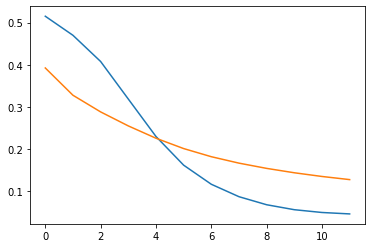

In [706]:
import matplotlib.pyplot as plt
plt.plot(SSNN2.loss)
plt.plot(SSNN2.val_loss)
plt.show()

In [714]:
# Accuracyは元の初期値よりさらに上がった
y_pred2=SSNN2.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred2)

0.9639

初期値をXavierで行ったことで、かなり効率的に適切な学習をしていることがlossの値からわかる。ただし、エポックを１０回ほど重ねると結果的に大きな差は生まれなかった。少ない学習回数で効率的な学習には適している初期値であることがわかった。

●活性化関数をReLUで行う

In [804]:
class ScratchSimpleNeuralNetrowkClassifier_A2():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self,ite_num, first_nodes,second_nodes,third_nodes,verbose = True):
        self.verbose = verbose
        self.ite_num=ite_num
        self.first_nodes=first_nodes
        self.second_nodes=second_nodes
        self.third_nodes=third_nodes
        self.loss = []
        self.val_loss = []      

 
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """ 
        #　初期設定の処理
        #  ReLUを前提とした設定
        SI1=SimpleInitializer(math.sqrt(2/X.shape[1]))
        optimizer1=SGD(0.01)
        self.FC1 = FC_B(X.shape[1],self.first_nodes,SI1,optimizer1)
        self.activation1=ReLU_func_B()
        
        SI2=SimpleInitializer(math.sqrt(2/self.first_nodes))
        optimizer2=SGD(0.01)
        self.FC2 = FC_B(self.first_nodes,self.second_nodes,SI2,optimizer2)
        self.activation2=ReLU_func_B()
        
        SI3=SimpleInitializer(math.sqrt(2/self.second_nodes))
        optimizer3=SGD(0.01)
        self.FC3 = FC_B(self.second_nodes,self.third_nodes,SI3,optimizer3)
        self.activation3=Softmax_func()
        
        
        # 処理を行う
        for _ in range(self.ite_num):
            get_mini_batch = GetMiniBatch(X,y,batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワード
                A1=self.FC1.forward(mini_X_train)
                Z1=self.activation1.ReLU_f(self.FC1.forward(mini_X_train))
                A2=self.FC2.forward(Z1)
                Z2=self.activation2.ReLU_f(A2)
                A3=self.FC3.forward(Z2)
                Z3=self.activation3.softmax_func_f(A3)
                # バック
                dA3=self.activation3.softmax_func_b(mini_y_train)
                dZ2=self.FC3.backward(dA3,Z2)
                dA2 = self.activation2.ReLU_b(dZ2)
                dZ1 = self.FC2.backward(dA2,Z1)
                dA1 = self.activation1.ReLU_b(dZ1)
                dZ0 = self.FC1.backward(dA1,mini_X_train) # dZ0は使用しない
              
            self.loss.append(self.activation3.total)
            
            if X_val is not None:                             
                A1_val=self.FC1.forward(X_val)
                Z1_val=self.activation1.ReLU_f(self.FC1.forward(X_val))
                A2_val=self.FC2.forward(Z1_val)
                Z2_val=self.activation2.ReLU_f(A2_val)
                A3_val=self.FC3.forward(Z2_val)
                Z3_val=self.activation3.softmax_func_f(A3_val) 
                dA3_val=self.activation3.softmax_func_b(y_val)            
                self.val_loss.append(self.activation3.total)  
            
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """        
        A1=self.FC1.forward(X)
        Z1=self.activation1.ReLU_f(self.FC1.forward(X))
        A2=self.FC2.forward(Z1)
        Z2=self.activation2.ReLU_f(A2)                
        A3=self.FC3.forward(Z2)
        Z3=self.activation3.softmax_func_f(A3)
        y_pred=np.argmax(Z3, axis=1)
        
        return y_pred

In [805]:
ite_num=10
first_nodes=400
second_nodes=200
third_nodes=10
SSNN3=ScratchSimpleNeuralNetrowkClassifier_A2(ite_num,first_nodes,second_nodes,third_nodes)
SSNN3.fit(X_train,y_train, X_val, y_val)

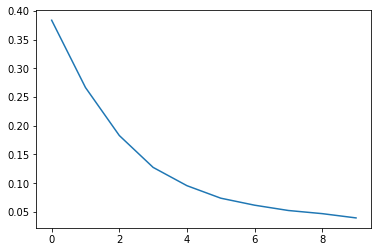

In [809]:
import matplotlib.pyplot as plt
plt.plot(SSNN3.loss)
#plt.plot(SSNN3.val_loss)
plt.show()

In [807]:
# Accuracyは元の初期値よりさらに上がった
y_pred3=SSNN3.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred3)

0.9709

●ノードの数を変更して行ってみる、ノードをも少し増やして行ってみる。関数はシグモイドで行う。

In [780]:
class ScratchSimpleNeuralNetrowkClassifier_A3():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self,ite_num, first_nodes,second_nodes,third_nodes,verbose = True):
        self.verbose = verbose
        self.ite_num=ite_num
        self.first_nodes=first_nodes
        self.second_nodes=second_nodes
        self.third_nodes=third_nodes
        self.loss = []
        self.val_loss = []      

 
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """ 
        #　初期設定の処理
        #  シグモイドを前提とした設定
        SI1=SimpleInitializer(1/math.sqrt(X.shape[1]))
        optimizer1=SGD(0.1)
        self.FC1 = FC_B(X.shape[1],self.first_nodes,SI1,optimizer1)
        self.activation1=Sigmo_func()
        
        SI2=SimpleInitializer(1/math.sqrt(self.first_nodes))
        optimizer2=SGD(0.1)
        self.FC2 = FC_B(self.first_nodes,self.second_nodes,SI2,optimizer2)
        self.activation2=Sigmo_func()
        
        SI3=SimpleInitializer(1/math.sqrt(self.second_nodes))
        optimizer3=SGD(0.1)
        self.FC3 = FC_B(self.second_nodes,self.third_nodes,SI3,optimizer3)
        self.activation3=Softmax_func()
        
        
        # 処理を行う
        for _ in range(self.ite_num):
            get_mini_batch = GetMiniBatch(X,y,batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワード
                A1=self.FC1.forward(mini_X_train)
                Z1=self.activation1.Sigmo_func_f(self.FC1.forward(mini_X_train))
                A2=self.FC2.forward(Z1)
                Z2=self.activation2.Sigmo_func_f(A2)
                A3=self.FC3.forward(Z2)
                Z3=self.activation3.softmax_func_f(A3)
                # バック
                dA3=self.activation3.softmax_func_b(mini_y_train)
                dZ2=self.FC3.backward(dA3,Z2)
                dA2 = self.activation2.Sigmo_func_b(dZ2)
                dZ1 = self.FC2.backward(dA2,Z1)
                dA1 = self.activation1.Sigmo_func_b(dZ1)
                dZ0 = self.FC1.backward(dA1,mini_X_train) # dZ0は使用しない
              
            self.loss.append(self.activation3.total)
            
            if X_val is not None:                             
                A1_val=self.FC1.forward(X_val)
                Z1_val=self.activation1.Sigmo_func_f(self.FC1.forward(X_val))
                A2_val=self.FC2.forward(Z1_val)
                Z2_val=self.activation2.Sigmo_func_f(A2_val)
                A3_val=self.FC3.forward(Z2_val)
                Z3_val=self.activation3.softmax_func_f(A3_val) 
                dA3_val=self.activation3.softmax_func_b(y_val)            
                self.val_loss.append(self.activation3.total)  
            
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """        
        A1=self.FC1.forward(X)
        Z1=self.activation1.Sigmo_func_f(self.FC1.forward(X))
        A2=self.FC2.forward(Z1)
        Z2=self.activation2.Sigmo_func_f(A2)                
        A3=self.FC3.forward(Z2)
        Z3=self.activation3.softmax_func_f(A3)
        y_pred=np.argmax(Z3, axis=1)
        
        return y_pred

In [781]:
ite_num=12
first_nodes=500
second_nodes=200
third_nodes=10
SSNN4=ScratchSimpleNeuralNetrowkClassifier_A3(ite_num,first_nodes,second_nodes,third_nodes)
SSNN4.fit(X_train,y_train, X_val, y_val)

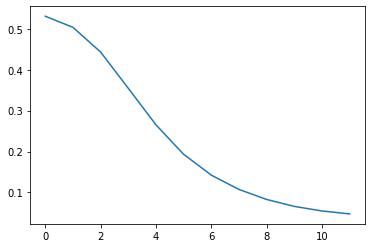

In [782]:
import matplotlib.pyplot as plt
plt.plot(SSNN4.loss)
#plt.plot(SSNN4.val_loss)
plt.show()

In [784]:
# Accuracyは元の初期値よりさらに上がった
y_pred4=SSNN4.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred4)

0.9625

ノードを増やしたが正解率にはそれほど変化はなかった。

●階層の数を１つ増やしてみる

In [792]:
class ScratchSimpleNeuralNetrowkClassifier_A4():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self,ite_num, first_nodes,second_nodes,third_nodes,fourth_nodes,verbose = True):
        self.verbose = verbose
        self.ite_num=ite_num
        self.first_nodes=first_nodes
        self.second_nodes=second_nodes
        self.third_nodes=third_nodes
        self.fourth_nodes=fourth_nodes
        self.loss = []
        self.val_loss = []      

 
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """ 
        #　初期設定の処理
        #  シグモイドを前提とした設定
        SI1=SimpleInitializer(1/math.sqrt(X.shape[1]))
        optimizer1=SGD(0.1)
        self.FC1 = FC_B(X.shape[1],self.first_nodes,SI1,optimizer1)
        self.activation1=Sigmo_func()
        
        SI2=SimpleInitializer(1/math.sqrt(self.first_nodes))
        optimizer2=SGD(0.1)
        self.FC2 = FC_B(self.first_nodes,self.second_nodes,SI2,optimizer2)
        self.activation2=Sigmo_func()
        
        SI3=SimpleInitializer(1/math.sqrt(self.second_nodes))
        optimizer3=SGD(0.1)
        self.FC3 = FC_B(self.second_nodes,self.third_nodes,SI3,optimizer3)
        self.activation3=Sigmo_func()
        
        
        SI4=SimpleInitializer(1/math.sqrt(self.second_nodes))
        optimizer4=SGD(0.1)
        self.FC4 = FC_B(self.third_nodes,self.fourth_nodes,SI4,optimizer4)
        self.activation4=Softmax_func()
        
        
        # 処理を行う
        for _ in range(self.ite_num):
            get_mini_batch = GetMiniBatch(X,y,batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワード
                A1=self.FC1.forward(mini_X_train)
                Z1=self.activation1.Sigmo_func_f(self.FC1.forward(mini_X_train))
                A2=self.FC2.forward(Z1)
                Z2=self.activation2.Sigmo_func_f(A2)                
                A3=self.FC3.forward(Z2)
                Z3=self.activation3.Sigmo_func_f(A3)                
                A4=self.FC4.forward(Z3)
                Z4=self.activation4.softmax_func_f(A4)
                # バック
                dA4=self.activation4.softmax_func_b(mini_y_train)
                dZ3=self.FC4.backward(dA4,Z3)
                dA3 = self.activation3.Sigmo_func_b(dZ3)
                dZ2 = self.FC3.backward(dA3,Z2)                                
                dA2 = self.activation2.Sigmo_func_b(dZ2)
                dZ1 = self.FC2.backward(dA2,Z1)
                dA1 = self.activation1.Sigmo_func_b(dZ1)
                dZ0 = self.FC1.backward(dA1,mini_X_train) # dZ0は使用しない
              
            self.loss.append(self.activation4.total)
            
            if X_val is not None:                             
                A1_val=self.FC1.forward(X_val)
                Z1_val=self.activation1.Sigmo_func_f(self.FC1.forward(X_val))
                A2_val=self.FC2.forward(Z1_val)
                Z2_val=self.activation2.Sigmo_func_f(A2_val)               
                A3_val=self.FC3.forward(Z2_val)
                Z3_val=self.activation3.Sigmo_func_f(A3_val)                
                A4_val=self.FC4.forward(Z3_val)
                Z4_val=self.activation4.softmax_func_f(A4_val) 
                dA4_val=self.activation4.softmax_func_b(y_val)            
                self.val_loss.append(self.activation4.total)  
            
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """        
        A1=self.FC1.forward(X)
        Z1=self.activation1.Sigmo_func_f(self.FC1.forward(X))
        A2=self.FC2.forward(Z1)
        Z2=self.activation2.Sigmo_func_f(A2)
        A3=self.FC3.forward(Z2)
        Z3=self.activation3.Sigmo_func_f(A3)        
        A4=self.FC4.forward(Z3)
        Z4=self.activation4.softmax_func_f(A4)
        y_pred=np.argmax(Z4, axis=1)
        
        return y_pred

In [793]:
ite_num=12
first_nodes=500
second_nodes=200
third_nodes=100
fourth_nodes=10
SSNN5=ScratchSimpleNeuralNetrowkClassifier_A4(ite_num,first_nodes,second_nodes,third_nodes,fourth_nodes)
SSNN5.fit(X_train,y_train, X_val, y_val)

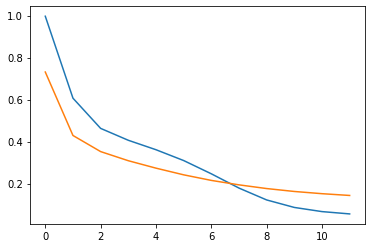

In [795]:
import matplotlib.pyplot as plt
plt.plot(SSNN5.loss)
plt.plot(SSNN5.val_loss)
plt.show()

In [796]:
# Accuracyは元の初期値よりさらに上がった
y_pred5=SSNN5.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred5)

0.9579

層を３層から４層にしたが、良い数値ではあるがAccuracyはあまり上昇しなかった。